## Initial algorithim with description

### Algorithm Steps

#### Libraries

In [45]:
import numpy as np
import scipy.stats as stats
import math

Our Algorithim is composed of 3 functions: Indian Buffet Process, log likelyhood function, and the Gibbs Sampler 

#### I. Indian Buffett Process

The Indian Buffett Process is used to initialize our Z matrix. The function is designed based on the following steps described in the paper. 

1. Initial customer takes the first Poisson($\alpha$) dishes  
2. The following ith customers:  
a. Take dishes that have previously been taken with probability of $\frac{m_k}{i}$ where $m_k$ is the number of customers who           have tried the dish  
b. Try Poisson($\alpha$/i) number of new dishes

In [46]:
def IBP(alpha,N):
    """ Indian Buffett Process"""
    k = alpha * N * 10
    Z = np.zeros((N,k))
    
    #initial customer
    d = np.random.poisson(alpha)
    Z[0,0:d] = 1

    k_new = d
    #Rest of the customers
    for i in range(1,N):
        for j in range(k_new):
            probability = np.sum(Z[0:i,j])/(i + 1)
            if probability > np.random.random():
                Z[i,j] = 1
        d = np.random.poisson(alpha/(i + 1))
        Z[i,k_new:k_new + d] = 1
        k_new += d
        
    return Z[:,0:k_new]
        
            

#### II. Log Likelyhood Function

This is a helper function that is frequently referenced during the Gibbs Sampler. It it is the log of the likelyhood of p(X | Z, $\sigma_X$, $\sigma_A$)

In [47]:
def log_likelyhood(N,D,K,sigma_X,sigma_A,Z):
    M = Z.T @ Z + (sigma_X**2/sigma_A**2)*np.eye(K)
    part1 = N*D/2 * np.log(2*np.pi) + (N - K)*D*np.log(sigma_X) + K*D*np.log(sigma_A)+D/2*np.log(np.linalg.det(M))
    part2_inside = np.eye(N) - (Z @ np.linalg.inv(M) @ Z.T)
    part2 = -1/(2 * sigma_X**2) * np.trace(X.T @ part2_inside @ X)
    return part2 - part1

#### III. Gibbs Sampler

This is the main portion of our function and does the following steps:  
1. For each $Z_{ik}$, sample to see if it is 0 or 1
2. Sample to see if more columns should be added (increase k) or potentially be removed
3. Update $\sigma_X$ as needed
4. Update $\sigma_A$ as needed
5. Compute new $\alpha$

In [92]:
def sampler(X,alpha,niter,epsilon,sigma_X,sigma_A,alpha_a_prior,alpha_b_prior,max_new):
    N = X.shape[0]
    D = X.shape[1]
    Z = IBP(alpha,N) # set inital Z
    K = Z.shape[1]
    K_values = np.zeros(niter)
    alpha_values = np.zeros(niter)
    Sigma_X_values = np.zeros(niter)
    Sigma_A_values = np.zeros(niter)
    HN = 0
    for i in range(1,N+1):
        HN += 1.0/i
    for runs in range(niter):
        for i in range(N):
            for j in range(K):
                #Sample Z given conditionals
                
                col_k_count = sum(Z[:,j]) - Z[i,j] #p(zik|z-ik) = 0 so we set to 0
                if col_k_count == 0:
                    Z[i,j] = 0
                    
                else:
                    Z[i,j] = 0
                    Z0_p = log_likelyhood(N,D,K,sigma_X,sigma_A,Z) + np.log(N - col_k_count)
                    Z[i,j] = 1
                    Z1_p = log_likelyhood(N,D,K,sigma_X,sigma_A,Z) + np.log(col_k_count)
                    L = Z1_p - Z0_p
                    p = np.exp(L)/(1 + np.exp(L))
                    if p > np.random.random():
                        Z[i,j] = 1
                    else:
                        Z[i,j] = 0
                        
            #Get rid of unneeded columns
#             Z = Z[:,np.sum(Z,axis = 0) != 0]
#             K = Z.shape[1]
            #Sample to see if new columns get added
            log_prob = np.zeros(max_new)
            a_N = alpha/N
            log_prob[0] = -a_N + log_likelyhood(N,D,Z.shape[1],sigma_X,sigma_A,Z)
            for new_ks in range(1,max_new):
                new_cols = np.zeros((N,new_ks))
                new_cols[i,:] = 1
                Z_new = np.hstack((Z,new_cols))
                #Poisson(alpha/n) * log likelyhood
                log_prob[new_ks] = new_ks*np.log(a_N) - a_N - np.log(math.factorial(new_ks)) + log_likelyhood(N,D,Z_new.shape[1],sigma_X,sigma_A,Z_new)
            #Convert log likelyhoods
            prob = np.exp(log_prob - max(log_prob))
            prob = prob/sum(prob)

            #Sample probabilites and add columns accordingly
            new_cols_add = list(np.random.multinomial(1,prob) == 1).index(1)
            col_k_count = np.sum(Z,axis = 0) - Z[i,:]
            if new_cols_add == 0:
                Z = Z[:,col_k_count != 0]
            else:
                newcols = np.zeros((N,new_cols_add))
                newcols[i,:] = 1
                Z = np.hstack((Z[:,col_k_count != 0],newcols))
            K = Z.shape[1]
        
        #Part2
        current_likelyhood = log_likelyhood(N,D,K,sigma_X,sigma_A,Z) 
        
        #Sigma_X
        sigma_X_new = sigma_X + np.random.uniform(-epsilon,epsilon)
        new_likelyhood = log_likelyhood(N,D,K,sigma_X_new,sigma_A,Z)
        if np.exp(min(0,new_likelyhood - current_likelyhood)) > np.random.random():
            sigma_X = sigma_X_new
            
        #Sigma_A
        sigma_A_new = sigma_A + np.random.uniform(-epsilon,epsilon)
        new_log_likelyhood = log_likelyhood(N,D,K,sigma_X,sigma_A_new,Z)
        if np.exp(min(0,new_likelyhood - current_likelyhood)) > np.random.random():
            sigma_A = sigma_A_new
         
        #Alpha
        alpha = np.random.gamma(alpha_a_prior + K,alpha_b_prior + 1/(1 + HN))
        
        K_values[runs] = K
        alpha_values[runs] = alpha
        Sigma_X_values[runs] = sigma_X
        Sigma_A_values[runs] = sigma_A
        print(runs,K,alpha,sigma_X,sigma_A)
    return(K_values,alpha_values,Sigma_X_values,Sigma_A_values,Z)

## Simulation

For this simulation, we will use the example images used in Ilker Yildirim's paper (https://www2.bcs.rochester.edu/sites/jacobslab/cheat_sheet/IndianBuffetProcess.pdf) to see if our algorithm can produce similar results. 

### Setup

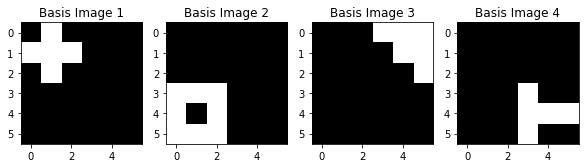

In [132]:
np.random.seed(1)
#We have 4 basis images: 
import matplotlib.pyplot as plt
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4,figsize = (10,4))
b1 = np.array([[0,1,0,0,0,0],
               [1,1,1,0,0,0],
               [0,1,0,0,0,0],
               [0,0,0,0,0,0],
               [0,0,0,0,0,0],
               [0,0,0,0,0,0]])

ax1.imshow(b1,cmap = "gray")
ax1.set_title("Basis Image 1")


b2 = np.array([[0,0,0,0,0,0],
               [0,0,0,0,0,0],
               [0,0,0,0,0,0],
               [1,1,1,0,0,0],
               [1,0,1,0,0,0],
               [1,1,1,0,0,0]])

ax2.imshow(b2,cmap = "gray")
ax2.set_title("Basis Image 2")


b3 = np.array([[0,0,0,1,1,1],
               [0,0,0,0,1,1],
               [0,0,0,0,0,1],
               [0,0,0,0,0,0],
               [0,0,0,0,0,0],
               [0,0,0,0,0,0]])

ax3.imshow(b3,cmap = "gray")
ax3.set_title("Basis Image 3")

b4 = np.array([[0,0,0,0,0,0],
               [0,0,0,0,0,0],
               [0,0,0,0,0,0],
               [0,0,0,1,0,0],
               [0,0,0,1,1,1],
               [0,0,0,1,0,0]])

ax4.imshow(b4,cmap = "gray")
ax4.set_title("Basis Image 4")
pass
N = 100
D = 36
b1 = b1.reshape(D)
b2 = b2.reshape(D)
b3 = b3.reshape(D)
b4 = b4.reshape(D)
sigmaX = 0.5

#Create X from basis vectors
x1 = np.outer(np.random.binomial(1,.5,100),b1)
x2 = np.outer(np.random.binomial(1,.5,100),b2)
x3 = np.outer(np.random.binomial(1,.5,100),b3)
x4 = np.outer(np.random.binomial(1,.5,100),b4)

X = x1 + x2 + x3 + x4
#Add noise
X = X + np.random.normal(0,.5,(100,36))

In [133]:
np.random.seed(10)
Ks_1,Alpha_1s,SXs_1,SAs_1,Z_1 = sampler(X,1,1000,.05,1,1,1,1,4)

0 3 5.615468852785111 1 1
1 2 1.0652640764930577 1 1
2 2 0.4921922244747843 0.9808155154509658 0.9513257447476215
3 2 3.3283997454294174 0.9808155154509658 0.9513257447476215
4 2 0.7684690240127374 0.9808155154509658 0.9513257447476215
5 2 5.381157632251649 0.9808155154509658 0.9513257447476215
6 2 1.1415896124987737 0.9808155154509658 0.9513257447476215
7 2 2.1350258281302095 0.9561028193619043 0.9120805327808149
8 2 4.259703422553343 0.9158474034832998 0.8785615890468079
9 2 1.5136746797205962 0.9158474034832998 0.8785615890468079
10 2 1.370005161125941 0.8758647967321249 0.874471661277357
11 2 2.2610415764606477 0.8758647967321249 0.874471661277357
12 2 6.307884456551857 0.8586078350228722 0.8559535211798205
13 2 3.6964427316601336 0.8586078350228722 0.8559535211798205
14 2 4.111806028590967 0.8257566616353835 0.8780482076779721
15 2 5.791741335174382 0.8199425805391962 0.8646281609700966
16 2 1.6081357471350326 0.779275913832193 0.8767942396583118
17 2 1.5940563449075316 0.73226966

136 3 4.239949854444682 0.528405098963658 0.8280617128612562
137 3 3.2279635353245957 0.528405098963658 0.8280617128612562
138 3 1.5142543529985921 0.528405098963658 0.8280617128612562
139 3 5.180048057390831 0.528405098963658 0.8280617128612562
140 3 3.2152890320661665 0.528405098963658 0.8280617128612562
141 3 6.543486699553156 0.5187654058442283 0.8280617128612562
142 4 7.904834400655413 0.5187654058442283 0.8280617128612562
143 3 4.4592124096839605 0.5379277415043816 0.8424229222620109
144 3 4.109803329232642 0.5379277415043816 0.8424229222620109
145 3 2.6381578011916855 0.5247728729881316 0.8526734577452982
146 3 6.85400363724696 0.5247728729881316 0.8526734577452982
147 3 3.018267367206262 0.5247728729881316 0.8526734577452982
148 4 8.141228265802763 0.5247728729881316 0.8526734577452982
149 4 15.097718335340295 0.5247728729881316 0.8526734577452982
150 4 12.68772627059339 0.5247728729881316 0.8526734577452982
151 5 6.056653070542869 0.5247728729881316 0.8526734577452982
152 4 1.

269 3 3.832140489279438 0.531054240132045 1.031694707113126
270 3 5.523956538375183 0.531054240132045 1.031694707113126
271 3 3.530016564091262 0.5284871566852791 1.055382224812204
272 3 3.4849824541174104 0.5284871566852791 1.055382224812204
273 3 4.258596813327223 0.5352525052747774 1.055382224812204
274 3 4.756677060885351 0.5352525052747774 1.055382224812204
275 3 5.012781490311683 0.5352525052747774 1.055382224812204
276 3 1.4254886395210813 0.5270176646660995 1.0621403588174783
277 3 2.632857258592722 0.5270176646660995 1.0621403588174783
278 3 3.6926653407521086 0.5270176646660995 1.0621403588174783
279 3 4.966253793967108 0.5270176646660995 1.0621403588174783
280 3 5.2288314219782 0.5270176646660995 1.0621403588174783
281 3 7.422025796645665 0.5270176646660995 1.0621403588174783
282 3 9.077337292298976 0.5270176646660995 1.0621403588174783
283 3 8.188253281515431 0.5270176646660995 1.0621403588174783
284 3 3.4506621425078765 0.5270176646660995 1.0621403588174783
285 3 3.3074576

402 3 2.570039112439521 0.5249618066694377 1.3570920447471024
403 3 4.205486398273537 0.5249618066694377 1.3570920447471024
404 3 7.265750006811196 0.5249618066694377 1.3570920447471024
405 3 8.357922736758463 0.5249618066694377 1.3570920447471024
406 3 3.0379237158286485 0.5249618066694377 1.3570920447471024
407 3 8.198165518663487 0.5249618066694377 1.3570920447471024
408 3 3.9589196582902573 0.5249618066694377 1.3570920447471024
409 3 4.819773130206579 0.5357907731881928 1.3570920447471024
410 3 1.1703485190429463 0.5357907731881928 1.3570920447471024
411 3 6.040753673139101 0.5279326705246054 1.3494358815179373
412 3 6.37403697865775 0.5269075396604886 1.317778729501478
413 3 4.082057088264155 0.5309680011343142 1.2737457422799086
414 3 2.71378547987171 0.5309680011343142 1.2737457422799086
415 3 4.273534511061815 0.5309680011343142 1.2737457422799086
416 3 7.439105175697053 0.5309680011343142 1.2737457422799086
417 3 5.771878956348225 0.5335977596839019 1.2737457422799086
418 3 1.

535 3 7.278908854171613 0.5268875309744854 1.2118218057743608
536 3 11.778431512737907 0.5268875309744854 1.2118218057743608
537 3 6.804592243838964 0.5243116336840485 1.2306800581848736
538 3 10.020278727159013 0.5243116336840485 1.2306800581848736
539 3 3.32741266417339 0.5243116336840485 1.2331421860253216
540 3 4.262170071616657 0.5243116336840485 1.2331421860253216
541 3 4.992431254160511 0.5243116336840485 1.2331421860253216
542 3 2.034439485322463 0.5336121532705699 1.231566316203921
543 3 9.802832418928615 0.5336121532705699 1.231566316203921
544 3 2.5094770128203323 0.5336121532705699 1.231566316203921
545 3 6.7135605484023175 0.5336121532705699 1.231566316203921
546 3 6.216658132037823 0.5336121532705699 1.231566316203921
547 3 2.276606385345808 0.5336121532705699 1.231566316203921
548 3 2.351609287886451 0.5336121532705699 1.231566316203921
549 3 16.065138370779618 0.5308043218278433 1.275962268052722
550 3 2.5123989025493065 0.5308043218278433 1.275962268052722
551 3 2.9145

667 3 3.289188335610802 0.5426009219958429 1.4015754768450066
668 3 5.9564718133780845 0.5426009219958429 1.4015754768450066
669 3 3.058931561526412 0.5415032347710218 1.4347477773944974
670 3 3.436001293038446 0.5415032347710218 1.4347477773944974
671 3 3.9830163482500365 0.5415032347710218 1.4347477773944974
672 3 4.005759870739853 0.5415032347710218 1.4347477773944974
673 3 3.5211393084687566 0.5415032347710218 1.4347477773944974
674 3 5.028781104290564 0.5415032347710218 1.4347477773944974
675 3 7.327146833383436 0.5415032347710218 1.4347477773944974
676 3 1.08402670597466 0.5415032347710218 1.4347477773944974
677 3 4.714178289724258 0.5415032347710218 1.4347477773944974
678 3 4.917472228279381 0.5415032347710218 1.4347477773944974
679 3 1.2994649867180554 0.5415032347710218 1.4347477773944974
680 3 9.59025032522279 0.5415032347710218 1.4347477773944974
681 3 4.6974970953932225 0.5415032347710218 1.4347477773944974
682 3 3.928262902372832 0.5415032347710218 1.4347477773944974
683 3

800 3 4.042941067147275 0.5294654676817535 1.1600904557631708
801 3 2.8638674469667587 0.5146104098378669 1.1600904557631708
802 3 0.8375479195458072 0.5146104098378669 1.1600904557631708
803 3 3.4102580939677707 0.5146104098378669 1.1600904557631708
804 3 3.1978137797955903 0.5146104098378669 1.1600904557631708
805 3 6.234705021048102 0.5146104098378669 1.200506023089216
806 3 6.899830476955098 0.5402061742104 1.1687217819739506
807 3 5.160047539097889 0.5402061742104 1.1687217819739506
808 3 3.625051386984313 0.5402061742104 1.1687217819739506
809 3 2.5225617390147828 0.5323249162026235 1.1593394098583238
810 3 4.886524231030765 0.5323249162026235 1.1593394098583238
811 3 1.8592460877491583 0.5323249162026235 1.1960982215086322
812 3 9.122231615251792 0.5323249162026235 1.1960982215086322
813 3 4.889501765306092 0.5323249162026235 1.1960982215086322
814 3 2.824643079510913 0.5346245709163536 1.1737617179643096
815 3 12.000904466183817 0.5346245709163536 1.1737617179643096
816 3 4.504

933 3 5.475834618422757 0.5282519210173884 1.2267332109723337
934 3 5.7071035420138285 0.5282519210173884 1.2267332109723337
935 3 3.0176411632699045 0.5282519210173884 1.2267332109723337
936 3 4.758113853174135 0.5282519210173884 1.2267332109723337
937 3 2.8247775518563674 0.5282519210173884 1.2267332109723337
938 3 4.8629162556571695 0.5282519210173884 1.1977246442470086
939 3 6.393453116560661 0.5282519210173884 1.1977246442470086
940 3 4.2945993699921035 0.5217836352577947 1.1977246442470086
941 3 10.032589086403775 0.5297993296083335 1.1728013252138403
942 3 5.547548029549389 0.5297993296083335 1.1728013252138403
943 3 3.8155097718270774 0.5297993296083335 1.1728013252138403
944 3 6.438488720330335 0.5297993296083335 1.1728013252138403
945 3 3.605123286879824 0.5297993296083335 1.1728013252138403
946 3 5.304191350824295 0.5297993296083335 1.1728013252138403
947 3 8.242913592879587 0.5297993296083335 1.1728013252138403
948 3 4.890327136733315 0.5297993296083335 1.1728013252138403
9

In [136]:
A = np.linalg.inv(Z_1.T @ Z_1 + SXs_1[999]**2 / SAs_1[999]**2 * np.eye(3)) @ Z_1.T @ X

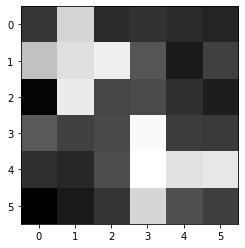

In [139]:
plt.imshow(A[2].reshape(6,6),cmap = "gray")

Text(0.5, 1.0, 'Sigma A')

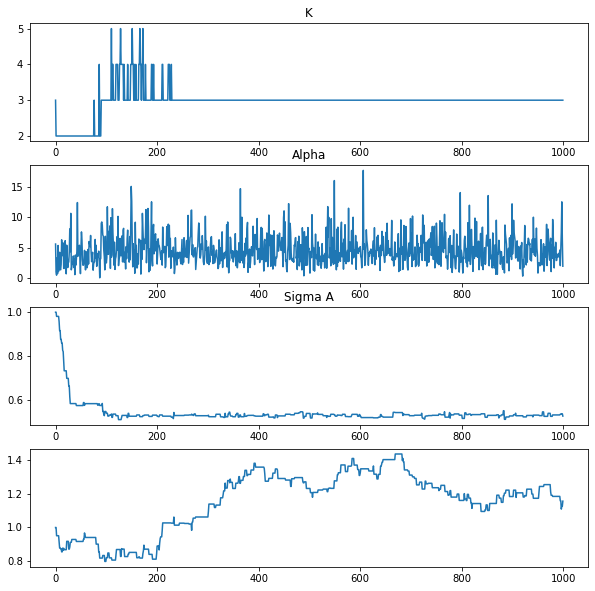

In [144]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1,figsize = (10,10))
ax1.plot(Ks_1)
ax1.set_title("K")
ax2.plot(Alpha_1s)
ax2.set_title("Alpha")
ax3.plot(SXs_1)
ax3.set_title("Sigma X")
ax4.plot(SAs_1)
ax3.set_title("Sigma A")

In [ ]:
# np.random.seed(10)
# Ks_2,Alpha_2s,SXs_2,SAs_2,Z_2 = sampler(X,1,1000,.05,1,1,1,1,4)